In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,brooklyn_zips,zip_list

from shapely import wkt

from IPython.display import display, Latex,Markdown
from tabulate import tabulate

In [2]:

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d39 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_39.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
finance = pd.read_csv('../../council_campaign_finance/data/located_data_subset_for_member_chapters.csv')
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
full_results_thirty_nine = full_results[full_results['district'] == 39]
full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10
sh_full = full_results[full_results['candidate'] ==  'Shahana K. Hanif']
bw_full = full_results[full_results['candidate'] ==  'Brandon West']
#sh_full = sh_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]
bw_full = bw_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]

d39 = make_edname(d39)
d39_eds = d39['ed_name'].unique().tolist()


max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

C:\Users\samtg\AppData\Local\Temp\ipykernel_22732\2497930016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10


In [117]:
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
cvap = pd.read_csv('../data/cvap.csv')
to_2020 = pd.read_csv('../data/brooklyn_20p_turnout.csv')

In [72]:
to_2020.columns = ['ed_name','to_2020']

In [84]:
demo_occ = sh_full[['vote_share','total_vote_precinct','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio','garcia213p','dpp20bs','hh21op']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [85]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')
demo_occ = demo_occ.merge(cvap,on='ElectDist',how='left')
demo_occ = demo_occ.merge(to_2020, on='ed_name',how='left')

In [86]:
demo_occ['turnout_2021'] = (demo_occ['cvap'] / demo_occ['total_vote_precinct']).round(3)
demo_occ['turnout_2020'] = (demo_occ['cvap'] / demo_occ['to_2020']).round(3)
demo_occ['turnout_diff'] = (demo_occ['turnout_2021'] - demo_occ['turnout_2020']).round(3)
demo_occ['south_asian'] = demo_occ['ind21p'] + demo_occ['bang21p']
demo_occ['dpp20bs'] = demo_occ['dpp20bs'] / 10

In [44]:
demo_occ[['ind21p','bang21p','south_asian','w2tranp','turnout_2020','turnout_2021','turnout_diff','vote_share']].corr()

,ind21p,bang21p,south_asian,w2tranp,turnout_2020,turnout_2021,turnout_diff,vote_share
ind21p,1.000000,0.598908,0.928010,0.360636,0.227393,0.075688,-0.214313,0.251221
bang21p,0.598908,1.000000,0.854142,0.376519,0.317974,0.237354,-0.193870,0.233566
south_asian,0.928010,0.854142,1.000000,0.409356,0.295594,0.159573,-0.229364,0.271799
w2tranp,0.360636,0.376519,0.409356,1.000000,0.361524,0.249208,-0.237040,0.112587
turnout_2020,0.227393,0.317974,0.295594,0.361524,1.000000,0.571049,-0.750832,-0.441913
turnout_2021,0.075688,0.237354,0.159573,0.249208,0.571049,1.000000,0.113448,-0.085314
turnout_diff,-0.214313,-0.193870,-0.229364,-0.237040,-0.750832,0.113448,1.000000,0.466200
vote_share,0.251221,0.233566,0.271799,0.112587,-0.441913,-0.085314,0.466200,1.000000


In [81]:
target = demo_occ['vote_share']
mod1 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','nhb21p','cvap21bapp','bang21p']])).fit()
mod2 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','nhb21p','cvap21bapp','bang21p','turnout_diff','white_transplant_ratio']])).fit()
mod3 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','nhb21p','cvap21bapp','bang21p','turnout_diff','white_transplant_ratio','w2admp','w2lawp','w2tranp','w2cossp','w2docp','w2emrp']])).fit()
mod4 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','nhb21p','cvap21bapp','bang21p','turnout_diff','white_transplant_ratio','w2admp','w2lawp','w2tranp','w2cossp','w2docp','w2emrp','garcia213p','dpp20bs']])).fit()

In [116]:
1679 + 66152 +  50551 + 21568 +  2275

142225

In [82]:
summary_col([mod1,mod2,mod3,mod4], stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII
const,40.4446***,34.2053***,26.4301***,14.0965***
,(2.3582),(2.3510),(2.6388),(3.2290)
nhw21p,-0.3585***,-0.1196***,-0.1245***,-0.0483
,(0.0314),(0.0371),(0.0338),(0.0356)
nhb21p,0.2043***,0.1639**,-0.1487*,0.0026
,(0.0787),(0.0754),(0.0844),(0.0823)
cvap21bapp,0.1879***,0.2487***,0.2141***,-0.1336**
,(0.0200),(0.0424),(0.0395),(0.0565)
bang21p,0.6260***,0.7784***,1.3890***,1.6877***
,(0.1817),(0.1729),(0.1534),(0.1552)


In [48]:
demo_map = ed_gdf.merge(demo_occ,how='left')

In [7]:
full_results_thirty_nine.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Shahana K. Hanif        11461.0
Brandon West             7978.0
Justin M. Krebs          5669.0
Douglas M. Schneider     4882.0
Briget Rein              2506.0
Jessica Simmons          1552.0
Mamnun M. Haq            1431.0
219478.0                  126.0
218085.0                  109.0
219449.0                  100.0
Write-in                   87.0
219463.0                   65.0
overvote                   59.0
221161.0                   27.0
219422.0                   25.0
218128.0                   23.0
Name: vote, dtype: float64

In [8]:
top_three = full_results_thirty_nine[full_results_thirty_nine['candidate'].isin(['Shahana K. Hanif','Brandon West','Justin M. Krebs'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [9]:
winners['candidate'].value_counts()

candidate
Shahana K. Hanif    100
Brandon West         27
Justin M. Krebs       6
Name: count, dtype: int64

In [10]:
def assign_color(row):
    if row['candidate'] == 'Shahana K. Hanif':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Brandon West':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [11]:
winners['color'] = winners.apply(assign_color, axis=1)

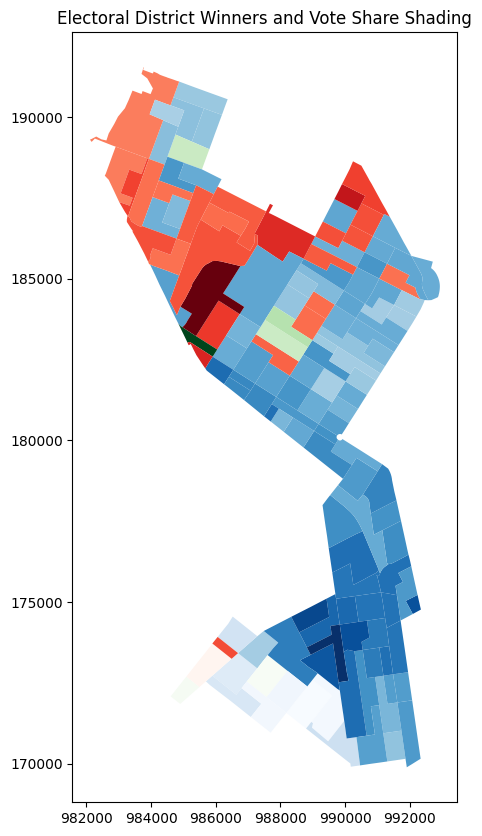

In [12]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [10]:
d39.groupby('district_39_choice_1')['district_39_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(10)

,district_39_choice_1,district_39_choice_2,count
59,Shahana K. Hanif,Brandon West,5003
0,Brandon West,Shahana K. Hanif,3762
60,Shahana K. Hanif,Justin M. Krebs,1888
61,Shahana K. Hanif,NaN,1818
20,Douglas M. Schneider,Justin M. Krebs,1640
1,Brandon West,NaN,1412
2,Brandon West,Justin M. Krebs,1390
39,Justin M. Krebs,NaN,1380
21,Douglas M. Schneider,NaN,1262
40,Justin M. Krebs,Shahana K. Hanif,1104


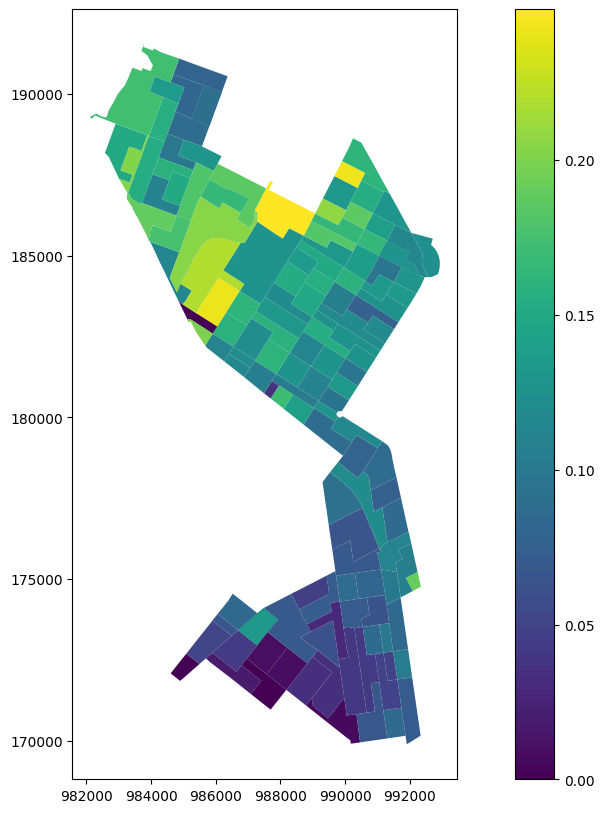

In [11]:
pc = make_precinct_counts(d39,'district_39','Shahana K. Hanif','Brandon West')
pc['total_votes'] = pc.iloc[:, 1:6].sum(axis=1)
pc = pc[['ed_name','Brandon West_notShahana K. Hanif','total_votes']]
pc.columns = ['ed_name','ch_notmh','total']
pc['ch_vote_share'] = pc['ch_notmh'] / pc['total']
el = full_results_thirty_nine[full_results_thirty_nine['winner'] == True]
map = pc.merge(el[['ed_name','geometry']],on='ed_name', how='left')
map = gpd.GeoDataFrame(map,geometry=map['geometry'].apply(wkt.loads))
map.plot(column='ch_vote_share', cmap='viridis', legend=True, figsize=(15, 10))
plt.show()

In [ ]:
cor_cols = ['ed_name','vote_share','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','ind21p','bang21p'] + wp_cols
corr_df = sh_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ed_name', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [14]:
thirty_nine = ['Shahana Hanif','Brandon West']
thirty_nine_df = finance[finance['matched_name'].isin(thirty_nine)]
by_zip_39 = thirty_nine_df.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index()
by_zip_39['ZIP'] = by_zip_39['ZIP'].astype(str)
compare = by_zip_39.pivot(index='ZIP',columns='matched_name',values='AMNT').fillna(0).reset_index()
compare_nyc = compare[compare['ZIP'].isin(zip_list)]

C:\Users\samtg\AppData\Local\Temp\ipykernel_24312\4289472305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_nyc['dif'] = compare_nyc['Shahana Hanif'] - compare_nyc['Brandon West']


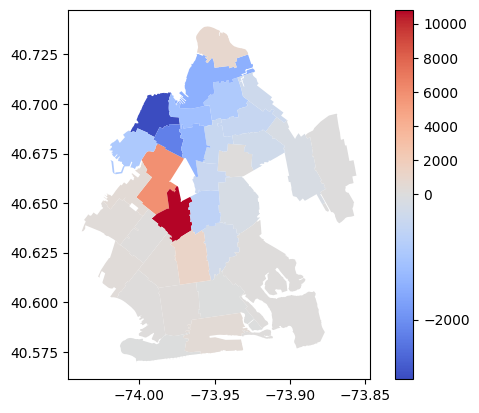

In [15]:
compare_nyc['dif'] = compare_nyc['Shahana Hanif'] - compare_nyc['Brandon West']
zip_map = compare_nyc.merge(nyc_zip, left_on='ZIP', right_on='zcta', how='left')
zip_map = gpd.GeoDataFrame(zip_map)

brooklyn_map = zip_map[zip_map['ZIP'].isin(brooklyn_zips)]
divnorm = colors.TwoSlopeNorm(vmin=brooklyn_map['dif'].min(), 
                              vcenter=0, 
                              vmax=brooklyn_map['dif'].max())
brooklyn_map.plot(column='dif', cmap='coolwarm', legend=True, norm=divnorm)
plt.show()

In [16]:
thirty_nine_df.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False).head(10)

,matched_name,ZIP,AMNT
413,Shahana Hanif,11215,15690.88
416,Shahana Hanif,11218,14495.00
116,Brandon West,11215,9778.08
118,Brandon West,11217,4652.55
105,Brandon West,11201,3948.00
119,Brandon West,11218,3679.82
134,Brandon West,11238,3383.67
117,Brandon West,11216,3290.02
129,Brandon West,11231,3106.71
414,Shahana Hanif,11216,2850.00


In [17]:
compare_nyc.sort_values('dif',ascending=True).head(10)

matched_name,ZIP,Brandon West,Shahana Hanif,dif
92,11201,3948.00,994.71,-2953.29
107,11217,4652.55,2436.00,-2216.55
102,11211,1919.11,451.88,-1467.23
126,11238,3383.67,2011.00,-1372.67
96,11205,1653.33,509.00,-1144.33
18,10024,1316.00,205.00,-1111.00
120,11231,3106.71,2176.00,-930.71
97,11206,976.36,80.00,-896.36
54,10463,972.00,173.00,-799.00
90,11106,1080.60,343.00,-737.60


In [18]:
thirty_nine_df.groupby('matched_name')['AMNT'].agg(['sum','mean','count'])

,sum,mean,count
matched_name,,,
Brandon West,75499.02,37.543023,2011
Shahana Hanif,86344.88,44.807929,1927


In [75]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])
corr_df['doc_mhhi_interaction'] = corr_df['log_mhhi21'] * corr_df['w2docp']
corr_df['adm_mhhi_interaction'] = corr_df['log_mhhi21'] * corr_df['w2admp']
corr_df['coss_mhhi_interaction'] = corr_df['w2cossp'] * corr_df['log_mhhi21']
corr_df['cvap_mhhi_interaction'] = corr_df['cvap21bapp'] * corr_df['log_mhhi21']

In [84]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp','garcia213p','dpp20bs']])).fit()
mod5 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp','garcia213p','dpp20bs','coss_mhhi_interaction']])).fit()

In [87]:
summary_col([mod1,mod2,mod3,mod4,mod5],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII,vote_share IIIII
const,38.4650***,30.3334***,24.0085***,16.6698***,49.0551***
,(6.7906),(6.7154),(6.5098),(6.0229),(17.8270)
log_mhhi21,-1.1744*,-1.1636*,-0.6612,-0.2547,-3.4626**
,(0.6541),(0.6175),(0.5664),(0.5205),(1.7421)
cvap21bapp,0.0828*,0.1790***,0.0530,-0.5147***,-0.4882***
,(0.0463),(0.0497),(0.0556),(0.1150),(0.1145)
bang21p,,1.6617***,2.1901***,2.3812***,2.4175***
,,(0.4089),(0.3637),(0.3308),(0.3277)
w2emrp,,,1.1697***,1.0915***,1.0828***
,,,(0.2715),(0.2505),(0.2478)


In [22]:
corr_df['garacia_hanif_diff'] = (corr_df['garcia213p'] - corr_df['vote_share']).round(2)
corr_df['dpp_hanif_diff'] = (corr_df['dpp20bs'] - corr_df['vote_share']).round(2)

In [23]:
corr_df[['garcia213p','dpp20bs','vote_share','garacia_hanif_diff','dpp_hanif_diff']].describe()

,garcia213p,dpp20bs,vote_share,garacia_hanif_diff,dpp_hanif_diff
count,130.000000,130.000000,130.000000,130.000000,130.000000
mean,67.265127,16.600915,31.604841,35.660231,-15.003615
std,20.234659,7.455262,10.242703,20.371388,11.530305
min,7.366398,1.475033,4.137931,-18.640000,-48.920000
25%,67.021499,11.447357,25.332828,25.237500,-23.730000
50%,75.587704,16.300000,31.887755,43.035000,-13.160000
75%,79.748739,22.332588,37.756546,50.312500,-6.490000
max,83.592169,29.200001,59.345794,62.160000,4.750000


In [24]:
conditions = [
    (corr_df['garacia_hanif_diff'] > 0) & 
    (corr_df['dpp_hanif_diff'] > 0),
    
    (corr_df['garacia_hanif_diff'] < 0) & 
    (corr_df['dpp_hanif_diff'] < 0),

    (corr_df['garacia_hanif_diff'] > 0) & 
    (corr_df['dpp_hanif_diff'] < 0),

    (corr_df['garacia_hanif_diff'] < 0) & 
    (corr_df['dpp_hanif_diff'] > 0)
]

values = ['garcia_bernie', 'hanif_hanif', 'garcia_hanif', 'hanif_bernie'] 
corr_df["vote_diff"] = np.select(conditions, values, default=0)

In [25]:
corr_df['vote_diff'].value_counts()

vote_diff
garcia_hanif     111
garcia_bernie     10
hanif_hanif        9
Name: count, dtype: int64

In [51]:
corr_df['south_asian'] = (corr_df['bang21p'] + corr_df['ind21p'])
corr_df['income_binary'] = np.where(corr_df['mhhi21'] > 70000, 1, 0)

In [52]:
corr_map = corr_df.merge(ed_gdf, left_on='ed_name', right_on='ElectDist', how='left')
corr_map = gpd.GeoDataFrame(corr_map,geometry=corr_map['geometry'])

In [53]:
corr_map['vote_diff'] = corr_map['vote_diff'].astype('category')
corr_map['income_binary'] = corr_map['income_binary'].astype('category')

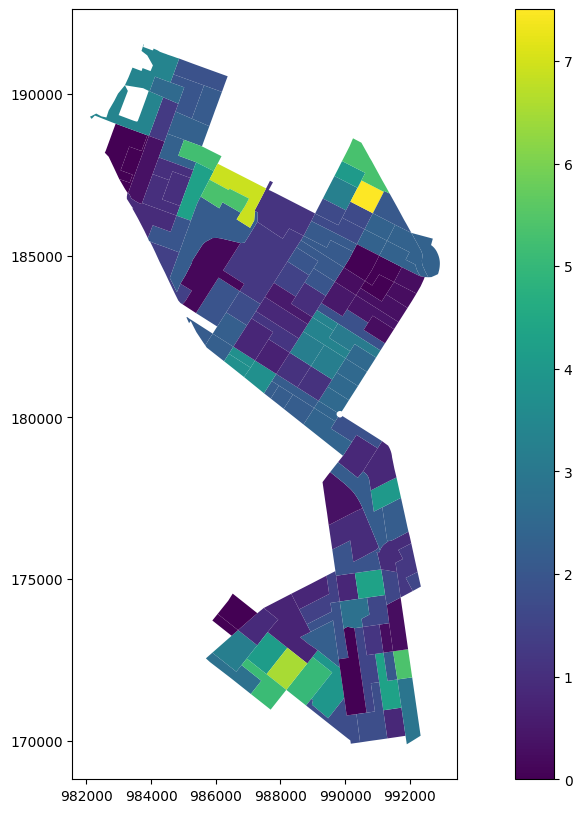

In [71]:
corr_map.plot(column='w2cossp', cmap='viridis', legend=True, figsize=(15, 10))
plt.show()

In [ ]:
target = corr_df['garacia_hanif_diff']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
summary_col([mod1,mod2,mod3],stars=True)

In [30]:
summary_col([mod1,mod2,mod3],stars=True)

,garacia_hanif_diff I,garacia_hanif_diff II,garacia_hanif_diff III
const,-30.1301***,-18.8963***,-13.5542**
,(6.4587),(5.9044),(6.2566)
log_mhhi21,0.6568,0.6419,0.2668
,(0.6222),(0.5429),(0.5444)
cvap21bapp,0.8850***,0.7520***,0.8145***
,(0.0440),(0.0437),(0.0535)
bang21p,,-2.2957***,-2.5696***
,,(0.3595),(0.3495)
w2emrp,,,-0.8829***
,,,(0.2609)


In [97]:
# make sh_full['ad'] which is the first two digits of ed_name
sh_full['ed_name'] = sh_full['ed_name'].astype(str)
sh_full['ad'] = sh_full['ed_name'].str[:2]

In [99]:
sh_full['ad'].value_counts()

ad
52    60
44    58
51     9
48     2
42     1
Name: count, dtype: int64

In [101]:
jb = pd.read_csv('../data/max_vote_share_candidates.csv')

In [105]:
jb['ad'] = jb['precinct'].str[3:6]

In [109]:
jb.rename(columns={'vote_share':'jb_vote'}, inplace=True)

In [111]:
jb_corr = jb[['ed_name','jb_vote']].merge(corr_df, left_on='ed_name', right_on='ed_name', how='left')

In [117]:
# find out how many ed_names jb and corr_df have in common
jb_corr['ed_name'].nunique(), corr_df['ed_name'].nunique()
jb_corr = jb_corr[jb_corr['ed_name'].isin(corr_df['ed_name'].unique())]
jb_corr

,ed_name,jb_vote,vote_share,dpp20bs,garcia213p,white_transplant_ratio,mhhi21,cvap21bapp,h21p,nha21p,...,pak21p,sril21p,taiw21p,thai21p,viet21p,log_mhhi21,doc_mhhi_interaction,adm_mhhi_interaction,coss_mhhi_interaction,cvap_mhhi_interaction
22,51008,66.97,35.087719,22.584519,69.413985,24.282011,21602.135779,77.393520,15.132485,6.500183,...,0.055494,0.0,1.479841e-01,0.0,0.000000e+00,9.980547,11.183991,99.195236,14.212291,772.429700
23,51044,72.60,27.586207,14.724878,74.305045,21.912690,55945.601422,60.852518,35.955614,8.827914,...,0.000000,0.0,1.203132e-01,0.0,0.000000e+00,10.932135,27.821636,126.116714,21.243579,665.247946
25,51046,63.64,40.000000,16.199170,71.761343,18.194420,9038.536642,58.812203,40.797965,11.365625,...,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,9.109253,12.711009,86.858559,19.596138,535.735215
62,52057,62.83,33.840304,17.557127,72.883676,27.932197,77189.334769,79.873326,17.504861,9.029411,...,0.000000,0.0,2.732483e-01,0.0,2.530549e-01,11.254017,25.165071,123.719376,36.331983,898.895731
63,52058,70.75,29.870130,23.499999,71.698117,25.355692,34494.621767,74.501186,12.398376,8.612805,...,0.000000,0.0,7.876015e-01,0.0,1.778455e-01,10.448559,34.048258,117.040910,17.556132,778.430019
64,52059,63.53,31.632653,23.500001,71.698116,25.355692,50688.744374,74.501186,12.398374,8.612805,...,0.000000,0.0,7.876017e-01,0.0,1.778455e-01,10.833459,35.302516,121.352401,18.202860,807.105559
65,52060,65.93,29.304029,23.499998,71.698113,25.355691,35860.159718,74.501186,12.398375,8.612804,...,0.000000,0.0,7.876015e-01,0.0,1.778456e-01,10.487382,34.174771,117.475771,17.621374,781.322413
66,52061,63.53,29.483283,16.899998,72.436745,26.502001,105363.904561,84.543754,14.853136,6.809078,...,0.000000,0.0,0.000000e+00,0.0,5.674232e-01,11.565175,62.391818,177.533087,86.781348,977.763348
67,52062,63.82,24.229075,14.400000,73.513511,29.300961,60361.453134,82.727269,20.217664,9.250732,...,0.000000,0.0,1.100920e-14,0.0,2.930096e-01,11.008106,18.635246,119.798005,44.591480,910.670544
68,52089,67.93,37.021277,22.100000,82.653064,28.793520,73413.827419,82.881140,12.437049,7.970222,...,0.240858,0.0,3.722356e-01,0.0,0.000000e+00,11.203868,70.397494,86.183607,23.465831,928.589314


In [118]:
target = jb_corr['vote_share']
mod1 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote']])).fit()
mod3 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote','bang21p']])).fit()
mod4 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
summary_col([mod1,mod2,mod3,mod4],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII
const,39.3109,49.9798,-16.4816,18.2263
,(24.0990),(38.4191),(40.9380),(46.5934)
log_mhhi21,-1.5899,-1.0575,-3.6180,-2.8038
,(3.1731),(3.5767),(3.1680),(3.3898)
cvap21bapp,0.0787,0.0156,0.7799*,0.7278*
,(0.2797),(0.3360),(0.4038),(0.3728)
jb_vote,,-0.1739,0.3324,-0.2883
,,(0.4785),(0.4464),(0.4554)
bang21p,,,6.0172**,7.4570
,,,(2.2634),(4.8713)


EFA

In [54]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [59]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [87]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [52]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','turnout_diff','garcia213p'] + wp_cols

In [106]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','ind21p','bang21p','turnout_diff','hh21op','w2admp','w2lawp','w2tranp','w2cossp','w2docp','w2emrp','garcia213p','dpp20bs','log_mhhi21']

In [107]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.50608983 0.18408311 0.34272427 0.57256304 0.82963941 0.86341771
 0.85180967 0.89498471 0.56747955 0.85737676 0.80434132 0.87071967
 0.47528315 0.83654254 0.43290516 0.81790863 0.84177555 0.64812196]
Overall KMO: 0.685585847640119
Bartlett’s test χ²: 9941.8091961899 p-value: 0.0


In [108]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'nhb21p' (KMO=0.184); new overall KMO before recalculation = 0.686
Dropping 'w2emrp' (KMO=0.251); new overall KMO before recalculation = 0.747


In [109]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

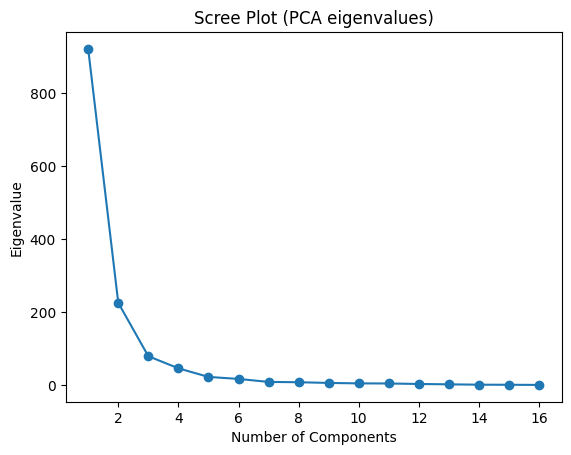

In [110]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [111]:
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [112]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [113]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                 Factor1    Factor2   Factor3
nhw21p        -5.576035  12.236510 -0.605912
h21p           1.946652  -5.123991 -0.985978
nha21p         4.991733  -5.288775  1.069317
cvap21bapp   -19.075112  -0.198252 -1.989629
ind21p         1.562365  -0.707749  0.373985
bang21p        1.367740  -0.787475  0.028618
turnout_diff  -2.546365  -2.203164  0.003493
hh21op        -4.070879   1.879746  8.403296
w2admp        -3.764768   0.149052  0.198869
w2lawp        -2.237709   0.140838 -0.095179
w2tranp        2.545721  -0.817633  0.088303
w2cossp        0.241242   0.252474 -0.293674
w2docp        -1.187265  -0.095391 -0.374015
garcia213p   -19.889558  -3.152514 -0.376581
dpp20bs       -5.368875   0.044526 -0.561513
log_mhhi21    -0.338867   0.120630 -0.133944


In [114]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     109.8
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           1.82e-57
Time:                        14:53:28   Log-Likelihood:                -2298.1
No. Observations:                 650   AIC:                             4604.
Df Residuals:                     646   BIC:                             4622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.6048      0.327     96.745      0.0

Donation Ethnicity

In [118]:
from ethnicolr import pred_census_ln, pred_wiki_name

c:\Users\samtg\github\member_chapters\venv\Lib\site-packages\ethnicolr\pred_census_ln.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [119]:
hanif_don = pd.read_csv('../data/hanif_don.csv')
west_don = pd.read_csv('../data/west_don.csv')
hanif_ind = hanif_don[hanif_don['C_CODE'] == 'IND']
west_ind = west_don[west_don['C_CODE'] == 'IND']

In [140]:
def import_dons(filepath):
    df = pd.read_csv(filepath)
    df_ind = df[df['C_CODE'] == 'IND']
    
    return df_ind

def split_name(name):
    if pd.isna(name):
        return pd.Series({"last":"", "first":""})
    name = str(name).strip()
    if ',' in name:
        last, first = name.split(',', 1)
        return pd.Series({"last": last.strip(), "first": first.strip()})
    parts = name.split()
    if len(parts) == 0:
        return pd.Series({"last":"", "first":""})
    if len(parts) == 1:
        return pd.Series({"last": parts[0], "first": ""})
    return pd.Series({"last": parts[-1], "first": " ".join(parts[:-1])})

def apply_split_names(df):
    name_parts = df['NAME'].apply(split_name)
    df = pd.concat([df, name_parts], axis=1)
    df['first'] = df['first'].astype(str)
    df['last'] = df['last'].astype(str)

    return df 

def run_ethnicolr(df):
    df_trim = df[['first','last','NAME','ZIP','AMNT']]
    df_with_eth = pred_wiki_name(df_trim.copy(), 'last', 'first')

    return df_with_eth

def import_trim_run(filepath):
    df = import_dons(filepath)
    split_df = apply_split_names(df)
    df_with_eth = run_ethnicolr(split_df)

    return df_with_eth

In [120]:
def split_name(name):
    if pd.isna(name):
        return pd.Series({"last":"", "first":""})
    name = str(name).strip()
    if ',' in name:
        last, first = name.split(',', 1)
        return pd.Series({"last": last.strip(), "first": first.strip()})
    parts = name.split()
    if len(parts) == 0:
        return pd.Series({"last":"", "first":""})
    if len(parts) == 1:
        return pd.Series({"last": parts[0], "first": ""})
    return pd.Series({"last": parts[-1], "first": " ".join(parts[:-1])})

In [121]:
def apply_split_names(df):
    name_parts = df['NAME'].apply(split_name)
    df = pd.concat([df, name_parts], axis=1)
    df['first'] = df['first'].astype(str)
    df['last'] = df['last'].astype(str)

    return df 

In [137]:
def run_ethnicolr(df):
    df_trim = df[['first','last','NAME','ZIP','AMNT']]
    df_with_eth = pred_wiki_name(df_trim.copy(), 'last', 'first')

    return df_with_eth

In [138]:
def import_trim_run(filepath):
    df = import_dons(filepath)
    split_df = apply_split_names(df)
    df_with_eth = run_ethnicolr(split_df)

    return df_with_eth

In [122]:
west_ind = apply_split_names(west_ind)
hanif_ind = apply_split_names(hanif_ind)

In [ ]:
df = west_ind[['first','last','NAME','ZIP','AMNT']]
west_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 17:07:22,978 - INFO - Processing 2038 names
2025-10-26 17:07:23,172 - INFO - Applying Wikipedia name model to 2038 processable names (confidence interval: 1.0)
2025-10-26 17:07:23,232 - INFO - Preserving 930 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 17:07:23,235 - INFO - Data filtering summary: 2038 → 2038 rows (kept 100.0%)
2025-10-26 17:07:26,803 - INFO - Successfully predicted 2038 of 2038 names (100.0%)
2025-10-26 17:07:26,809 - INFO - Added columns: GreaterAfrican,Muslim, processing_status, GreaterEuropean,Jewish, GreaterEuropean,WestEuropean,Hispanic, Asian,IndianSubContinent, Asian,GreaterEastAsian,EastAsian, GreaterAfrican,Africans, GreaterEuropean,WestEuropean,Italian, GreaterEuropean,WestEuropean,French, __name, name_normalized_clean, name_normalized, GreaterEuropean,British, GreaterEuropean,EastEuropean, GreaterEuropean,WestEuropean,Nordic, Asian,GreaterEastAsian,Japanese, race, GreaterEuropean,WestEuropean,Germanic


In [124]:
df = hanif_ind[['first','last','NAME','ZIP','AMNT']]
orig_cols = set(df.columns)
hanif_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 17:07:45,777 - INFO - Processing 1946 names
2025-10-26 17:07:45,849 - INFO - Applying Wikipedia name model to 1946 processable names (confidence interval: 1.0)
2025-10-26 17:07:45,871 - INFO - Preserving 730 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 17:07:45,873 - INFO - Data filtering summary: 1946 → 1946 rows (kept 100.0%)
2025-10-26 17:07:47,649 - INFO - Successfully predicted 1946 of 1946 names (100.0%)
2025-10-26 17:07:47,652 - INFO - Added columns: GreaterAfrican,Muslim, processing_status, GreaterEuropean,Jewish, GreaterEuropean,WestEuropean,Hispanic, Asian,IndianSubContinent, Asian,GreaterEastAsian,EastAsian, GreaterAfrican,Africans, GreaterEuropean,WestEuropean,Italian, GreaterEuropean,WestEuropean,French, __name, name_normalized_clean, name_normalized, GreaterEuropean,British, GreaterEuropean,EastEuropean, GreaterEuropean,WestEuropean,Nordic, Asian,GreaterEastAsian,Japanese, race, GreaterEuropean,WestEuropean,Germanic


In [125]:
west_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

,race,mean,sum,count
5,"GreaterEuropean,British",37.676,46944.51,1246
7,"GreaterEuropean,Jewish",40.891,11899.20,291
11,"GreaterEuropean,WestEuropean,Italian",36.074,2921.97,81
10,"GreaterEuropean,WestEuropean,Hispanic",26.357,2055.84,78
8,"GreaterEuropean,WestEuropean,French",33.357,2301.65,69
12,"GreaterEuropean,WestEuropean,Nordic",41.235,2061.77,50
0,"Asian,GreaterEastAsian,EastAsian",28.263,1384.87,49
2,"Asian,IndianSubContinent",41.218,1813.59,44
3,"GreaterAfrican,Africans",32.225,1289.00,40
6,"GreaterEuropean,EastEuropean",26.124,1018.84,39


In [126]:
hanif_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

,race,mean,sum,count
5,"GreaterEuropean,British",35.688,25266.89,708
4,"GreaterAfrican,Muslim",61.166,17738.00,290
2,"Asian,IndianSubContinent",44.597,11506.00,258
7,"GreaterEuropean,Jewish",45.828,11273.65,246
0,"Asian,GreaterEastAsian,EastAsian",46.529,5025.09,108
10,"GreaterEuropean,WestEuropean,Hispanic",41.435,3314.82,80
11,"GreaterEuropean,WestEuropean,Italian",61.272,4472.88,73
3,"GreaterAfrican,Africans",28.569,1771.25,62
8,"GreaterEuropean,WestEuropean,French",51.460,2573.00,50
6,"GreaterEuropean,EastEuropean",40.682,895.00,22


In [141]:
p_san = import_trim_run('../data/hanif_don.csv')

2025-10-26 17:29:31,524 - INFO - Processing 1946 names
2025-10-26 17:29:31,790 - INFO - Applying Wikipedia name model to 1946 processable names (confidence interval: 1.0)
2025-10-26 17:29:31,880 - INFO - Preserving 730 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 17:29:31,884 - INFO - Data filtering summary: 1946 → 1946 rows (kept 100.0%)
2025-10-26 17:29:37,482 - INFO - Successfully predicted 1946 of 1946 names (100.0%)
2025-10-26 17:29:37,488 - INFO - Added columns: GreaterAfrican,Muslim, processing_status, GreaterEuropean,Jewish, GreaterEuropean,WestEuropean,Hispanic, Asian,IndianSubContinent, Asian,GreaterEastAsian,EastAsian, GreaterAfrican,Africans, GreaterEuropean,WestEuropean,Italian, GreaterEuropean,WestEuropean,French, __name, name_normalized_clean, name_normalized, GreaterEuropean,British, GreaterEuropean,EastEuropean, GreaterEuropean,WestEuropean,Nordic, Asian,GreaterEastAsian,Japanese, race, GreaterEuropean,WestEuropean,Germanic
